In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 26 2022
Last revised on Mon Mar 18 2024

A Jupyer Notebook for Multimodal integration of neuroimaging and genetic data for the diagnosis of mood disorders based on computer vision models
ViT-XGBoost (imaging genomics)

@author: 


"""

'\nCreated on Sat Feb 26 2022\nLast revised on Thu Apr 20 2023\n\nA Jupyer Notebook for Multimodal integration of neuroimaging and genetic data for the diagnosis of mood disorders based on computer vision models\nViT-XGBoost (imaging genomics)\n\n@author: \n\n\n'

In [2]:
from tqdm import tqdm
from glob import glob
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import torchsummary
from collections import OrderedDict
import cv2
import xgboost as xgb
from xgboost import plot_importance

%matplotlib inline

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/koreagen/koreagen/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.13.1-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/koreagen/koreagen/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/koreagen/koreagen/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(256)
torch.cuda.manual_seed(256)
torch.cuda.manual_seed_all(256)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


In [5]:
scaler = StandardScaler()

In [6]:
ctrlvalue = []

temp = os.listdir("/path/to/control/")
for i in range(len(temp)):
     os.chdir(os.path.join("/path/to/control/", temp[i]))
     temp2 = os.listdir(os.getcwd())
     for j in range(len(temp2)):
         if temp2[j][-3:] == 'nii':
             nii = nib.load(os.path.join(os.getcwd(), temp2[j])).get_fdata()
             nii2 = nii.reshape(512, -1)
             nii2 = nii2[80:410, :]
             nii3 = scaler.fit_transform(nii2)
             ctrlvalue.append(nii3)

In [7]:
for i in range(len(ctrlvalue)):
    ctrlvalue[i] = cv2.resize(ctrlvalue[i], (384, 384), interpolation= cv2.INTER_LANCZOS4)

In [8]:
for i in range(len(ctrlvalue)):
    ctrlvalue[i] = torch.stack([torch.tensor(ctrlvalue[i]), torch.tensor(ctrlvalue[i]), torch.tensor(ctrlvalue[i])], dim=0)

In [9]:
mddvalue = []

temp = os.listdir("/path/to/MDD/")
for i in range(len(temp)):
     os.chdir(os.path.join("/path/to/MDD/", temp[i]))
     temp2 = os.listdir(os.getcwd())
     for j in range(len(temp2)):
         if temp2[j][-3:] == 'nii':
             nii = nib.load(os.path.join(os.getcwd(), temp2[j])).get_fdata()
             nii2 = nii.reshape(512, -1)
             nii2 = nii2[80:410, :]
             nii3 = scaler.fit_transform(nii2)
             mddvalue.append(nii3)

In [10]:
for i in range(len(mddvalue)):
    mddvalue[i] = cv2.resize(mddvalue[i], (384, 384), interpolation= cv2.INTER_LANCZOS4)

In [11]:
for i in range(len(mddvalue)):
    mddvalue[i] = torch.stack([torch.tensor(mddvalue[i]), torch.tensor(mddvalue[i]), torch.tensor(mddvalue[i])], dim=0)

In [12]:
bipvalue = []

temp = os.listdir("/path/to/bipolar/")
for i in range(len(temp)):
     os.chdir(os.path.join("/path/to/bipolar/", temp[i]))
     temp2 = os.listdir(os.getcwd())
     for j in range(len(temp2)):
         if temp2[j][-3:] == 'nii':
             nii = nib.load(os.path.join(os.getcwd(), temp2[j])).get_fdata()
             nii2 = nii.reshape(512, -1)
             nii2 = nii2[80:410, :]
             nii3 = scaler.fit_transform(nii2)
             bipvalue.append(nii3)

In [13]:
for i in range(len(bipvalue)):
    bipvalue[i] = cv2.resize(bipvalue[i], (384, 384), interpolation= cv2.INTER_LANCZOS4)

In [14]:
for i in range(len(bipvalue)):
    bipvalue[i] = torch.stack([torch.tensor(bipvalue[i]), torch.tensor(bipvalue[i]), torch.tensor(bipvalue[i])], dim=0)

In [15]:
data1 = ctrlvalue + mddvalue + bipvalue

In [17]:
idlist = pd.read_csv("id_list_for_fusion.csv").drop(['Unnamed: 0'], axis = 1)

In [18]:
idlist

,0
0,24
1,52
2,93
3,54
4,49
...,...
316,61
317,16
318,12
319,0


In [19]:
data = []
for i in range(len(data1)):
    data.append(data1[idlist.loc[i, :].item()])

In [20]:
len(data)

321

In [21]:
snp = pd.read_csv('snp.csv').drop(['Unnamed: 0'],axis=1)
snp

,chr1:8418644:C:A_C,chr1:8418650:T:C_T,chr1:8421203:T:C_T,chr1:8422676:T:C_T,chr1:8526142:G:A_G,chr1:8557320:C:G_C,chr1:8557691:A:C_A,chr1:52289220:TGTATTAAGGTCAA:T_TGTATTAAGGTCAA,chr1:52293570:G:A_G,chr1:52306063:ATCT:A_ATCT,...,chr19:19359854:TTGTGTGTG:T_T,chr19:19359854:T:TTGTG_TTGTG,chr20:47639464:G:C_G,chr20:47675176:T:A_T,chr22:41215421:G:GGC_G,chr22:41215421:G:GGT_GGT,chr22:42525952:C:A_C,chr22:42537023:T:C_T,chr22:42538399:C:T_C,chr22:42539623:C:A_C
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,1.0,NaN,1.0,0.0,0.0,0.0,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN
317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN
318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0
319,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,0.0,NaN,1.0


In [22]:
idx_list = []
for i in range(len(data)):
  idx_list.append(i)

print(idx_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [23]:
original = pd.read_csv("target.csv")
original['trait']

0      Control
1      Control
2      Control
3      Control
4      Control
        ...   
316    Control
317    Control
318    Control
319    Control
320    Control
Name: trait, Length: 321, dtype: object

In [24]:
# Control: 0, MDD: 1, Bipolar: 2 

target = []
for i in range(321):
  if original['trait'][i] == 'Control':
    target.append(0)
  elif original['trait'][i] == 'MDD':
    target.append(1)
  else:
    target.append(2)

In [25]:
# train / test split (9 : 1)

from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(idx_list, test_size = 0.1, shuffle = True, random_state = 256)

In [26]:
target = np.array(target)
len(target)

321

In [27]:
np.array(idx_train)

array([270, 281, 301,  86,  42, 168, 269, 315,  72, 275, 262,  73, 178,
       254,   6,  94,   8, 111, 259,  10, 225, 112,  47, 248,  74, 291,
       261,  43, 295,  20, 280, 185,  60, 277, 143,  29, 241, 317,  79,
       258, 145,  41, 278, 109,  50, 222, 200, 105, 182,  39, 237, 108,
       232, 205, 199,  44,  21, 209, 250, 228, 183, 318,  49,  30, 204,
       276, 103, 191, 226, 224,  76, 244, 147,  92,   5, 305, 149, 106,
       221, 210,  51, 187,  19, 267, 319,  34, 231, 286, 189,  16, 246,
       265, 144, 193, 233, 190, 133, 264,  53, 161,  81,  98,  37, 268,
       303,  83,  23, 159, 129,  54,  38, 213, 242, 107, 135, 279,  64,
       123, 151,   7,  99, 195, 229,  17, 218,  11, 158, 206, 100,  59,
         0,  40,  13, 175,  18, 288, 184, 140,  46,  55, 217, 141, 128,
       155, 153, 116, 294,  45,  82,  93,  75, 142, 273,  15, 251, 134,
       196, 238, 126, 115, 271, 298, 282, 101, 181, 192, 211,  96, 306,
       114, 308, 113, 110, 131, 219, 121,  66, 312, 320, 252, 28

In [28]:
np.array(idx_test)

array([ 31,   2,  91, 125, 203, 132, 257, 119, 180, 177, 302, 292, 166,
       296, 197, 230, 202, 243, 297,   3, 208, 165, 154,  69, 212, 104,
        26, 148, 309, 253, 171, 137,  77])

In [29]:
traindata = []
traindata_snp = []
trainidx = []
for i in range(len(idx_train)):
  traindata.append(data[idx_train[i]])
  traindata_snp.append(snp.loc[idx_train[i], :].values)
  trainidx.append(target[idx_train[i]])

In [30]:
testdata = []
testdata_snp = []
testidx = []

for i in range(len(idx_test)):
  testdata.append(data[idx_test[i]])
  testdata_snp.append(snp.loc[idx_test[i], :].values)
  testidx.append(target[idx_test[i]])

In [31]:
trainidx = np.array(trainidx)
testidx = np.array(testidx)

In [32]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

model = timm.create_model('vit_large_patch32_384', pretrained=True).cuda()

for parameter in model.parameters():
    parameter.requires_grad = False

num_features = model.head.in_features
model.head = nn.Linear(num_features, 3)
model = model.cuda()

In [33]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
    

In [34]:
batchsize = 32

In [35]:
testfinal = []
testfinal2 = []

for i in range(len(testdata)):
    testfinal.append((testdata[i], testidx[i]))
    testfinal2.append((testdata_snp[i], testidx[i]))

In [36]:
testloader = DataLoader(testfinal, batch_size = batchsize, shuffle = False)
testloader2 = DataLoader(testfinal2, batch_size = batchsize, shuffle = False)

In [37]:
# optimizer, loss function, learning rate scheduler, epoch 

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch : 0.95 ** epoch)
epochs = 100

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  prob=[]
  labellist=[]
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(device, dtype=torch.float)
    label = label.to(device)
    labellist.append(label)
    optimizer.zero_grad()
    output = model(image)
    prob.append(output)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    
    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
      
  scheduler.step()
  return prob, labellist

In [41]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    temp1 = []
    temp2 = []
    prob = []

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device, dtype = torch.float)

            label = label.to(device)
            temp1.append(label)
            output = model(image)
            prob.append(output)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            temp2.append(prediction)
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy, temp1, temp2, prob

In [42]:
def evaluate2(model, test_loader):
    model.eval()
    
    snpdata = []
    snplabel = []

    with torch.no_grad():
        for image, label in test_loader:
            snpdata.append(image)
            snplabel.append(label)
    
    return snpdata, snplabel

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

kfold = 10
skf = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 256)

In [44]:
traindata1 = np.array(traindata)

/tmp/ipykernel_562499/342623223.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  traindata1 = np.array(traindata)
/tmp/ipykernel_562499/342623223.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traindata1 = np.array(traindata)


In [48]:
assert len(traindata1) == len(traindata2)

In [49]:
params = {'max_depth':7, 'eta':0.1, 'objective':'multi:softprob', 'eval_metric':'mlogloss', 'early_stopping':100, 'num_class':3, 'n_estimators':1000}
num_rounds = 1000

In [51]:
image_testlabel = []
image_testpred = []
image_testloss = []
image_testacc = []
image_testprob = []
cv_acc = []
finalprob = []
finalpred = []

for i, (train_index, val_index) in enumerate(skf.split(traindata1, trainidx)):
    
    print('[Fold %d/%d]' % (i + 1, kfold))
    
    
    X_train, X_valid = traindata1[train_index], traindata1[val_index]
    X_train2, X_valid2 = traindata2[train_index], traindata2[val_index]
    y_train, y_valid = trainidx[train_index], trainidx[val_index]

    
    trainfinal = []
    trainfinal2 = []

    for j in range(X_train.shape[0]):
      trainfinal.append((X_train[j], y_train[j]))
      trainfinal2.append((X_train2[j], y_train[j]))


    valfinal = []
    valfinal2 = []

    for j in range(X_valid.shape[0]):
      valfinal.append((X_valid[j], y_valid[j]))
      valfinal2.append((X_valid2[j], y_valid[j]))

    trainloader = DataLoader(trainfinal, batch_size = batchsize, shuffle = False)
    trainloader2 = DataLoader(trainfinal2, batch_size = batchsize, shuffle = False)
    validloader = DataLoader(valfinal, batch_size = batchsize, shuffle = False)
    validloader2 = DataLoader(valfinal2, batch_size = batchsize, shuffle = False)
    
    
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    

    # train phase
    epochval = []
    valloss = []
    valacc = []

    for epoch in range(1, epochs + 1):
        trainprob, trainlabel = train(model, trainloader, optimizer, log_interval = 5)
        valid_loss, valid_accuracy, validlabel, _, validprob = evaluate(model, validloader)
        epochval.append(epoch)
        valloss.append(valid_loss)
        valacc.append(valid_accuracy)
        print("\n[EPOCH: {}], \tValidation Loss: {:.6f}, \tValidation Accuracy: {:.6f} % \n".format(
            epoch, valid_loss, valid_accuracy))
    

    # test phase

    test_loss, test_accuracy, label, pred, prob = evaluate(model, testloader)
    image_testlabel.append(label)
    image_testpred.append(pred)
    image_testloss.append(test_loss)
    image_testacc.append(test_accuracy)
    image_testprob.append(prob)

    print("\nTest Loss: {:.4f}, \tTest Accuracy: {:.4f} % \n".format(test_loss, test_accuracy))

    ## train phase

    vittrainprob = torch.cat((trainprob[0], trainprob[1], trainprob[2], trainprob[3], trainprob[4], trainprob[5], trainprob[6], trainprob[7], trainprob[8]),0).detach().cpu().numpy()
    vittrainlabel = torch.cat((trainlabel[0], trainlabel[1], trainlabel[2], trainlabel[3], trainlabel[4], trainlabel[5], trainlabel[6], trainlabel[7], trainlabel[8]),0).detach().cpu().numpy()
   
    # genomic data
    trainsnpdata, trainsnplabel = evaluate2(model, trainloader2)
    a = trainsnpdata
    b = trainsnplabel
    
    snpdatatrain = torch.cat((a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8]),0).detach().cpu().numpy()
    trainlabelgiven = torch.cat((b[0], b[1], b[2], b[3], b[4], b[5], b[6], b[7], b[8]),0).detach().cpu().numpy()
    
    snp_data_train = pd.DataFrame(snpdatatrain)
    snp_data_train['target'] = trainlabelgiven.reshape(len(trainlabelgiven), 1)

    
    assert (vittrainlabel == trainlabelgiven).all()
    
    # fusion_data_train = np.concatenate((vittrainprob, snpdatatrain), axis=1)
    # fusion_data_train = pd.DataFrame(fusion_data_train)
    # fusion_data_train['target'] = trainlabelgiven.reshape(len(trainlabelgiven), 1)

    ## validation phase
    vitvalidprob = validprob[0].detach().cpu().numpy()
    vitvalidlabel = validlabel[0].detach().cpu().numpy()
    
    validsnpdata, validsnplabel = evaluate2(model, validloader2)
    c = validsnpdata
    d = validsnplabel
    
    snpdatavalid = c[0].detach().cpu().numpy()
    validlabelgiven = d[0].detach().cpu().numpy()
    
    snp_data_valid = pd.DataFrame(snpdatavalid)
    snp_data_valid['target'] = validlabelgiven.reshape(len(validlabelgiven), 1)
    
    assert (vitvalidlabel == validlabelgiven).all()
    
    # fusion_data_valid = np.concatenate((vitvalidprob, snpdatavalid), axis=1)
    # fusion_data_valid = pd.DataFrame(fusion_data_valid)
    # fusion_data_valid['target'] = validlabelgiven.reshape(len(validlabelgiven), 1)

    ## test
    vittestprob = np.concatenate((prob[0].detach().cpu().numpy(), prob[1].detach().cpu().numpy()))
    vittestlabel = np.concatenate((label[0].detach().cpu().numpy(), label[1].detach().cpu().numpy()))
    
    testsnpdata, testsnplabel = evaluate2(model, testloader2)
    
    snpdatatest = np.concatenate((testsnpdata[0].detach().cpu().numpy(), testsnpdata[1].detach().cpu().numpy()))
    testlabelgiven = np.concatenate((testsnplabel[0].detach().cpu().numpy(), testsnplabel[1].detach().cpu().numpy()))
    
    snp_data_test = pd.DataFrame(snpdatatest)
    snp_data_test['target'] = testlabelgiven.reshape(len(testlabelgiven), 1)

    assert (vittestlabel == testlabelgiven).all()

    
    # fusion_data_test = np.concatenate((vittestprob, snpdatatest), axis=1)
    # fusion_data_test = pd.DataFrame(fusion_data_test)
    # fusion_data_test['target'] = labeltestgiven.reshape(33, 1)


    X_train_new, X_valid_new = snp_data_train.drop(['target'],axis=1), snp_data_valid.drop(['target'],axis=1)
    y_train_new, y_valid_new = snp_data_train['target'].values, snp_data_valid['target'].values

    ## xgboost
    d_train = xgb.DMatrix(X_train_new, y_train_new)
    d_valid = xgb.DMatrix(X_valid_new, y_valid_new)
    d_test = xgb.DMatrix(snp_data_test.drop(['target'],axis=1), snp_data_test['target'].values)

    wlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model = xgb.train(params = params, dtrain = d_train, num_boost_round = num_rounds, early_stopping_rounds = 200, evals = wlist)


    temp = xgb_model.predict(d_test)
    addition = vittestprob + temp
    m = torch.nn.Softmax()
    addition = m(torch.tensor(addition)).detach().cpu().numpy()
    finalprob.append(addition)
    
    temp2 = []
    
    for j in range(len(testidx)):
      temp2.append(np.argsort(addition[j])[::-1][0])
      
    acc = np.round(accuracy_score(testidx, temp2), 4)
    
    cv_acc.append(acc)
    finalpred.append(temp2)

[Fold 1/10]
[Fold 1/10 Prediciton:]
Train Epoch: 1 [0/259 (0%)]	Train Loss: 1.139391
Train Epoch: 1 [160/259 (56%)]	Train Loss: 0.705568

[EPOCH: 1], 	Validation Loss: 0.024358, 	Validation Accuracy: 75.862069 % 

Train Epoch: 2 [0/259 (0%)]	Train Loss: 0.578178
Train Epoch: 2 [160/259 (56%)]	Train Loss: 0.626871

[EPOCH: 2], 	Validation Loss: 0.024713, 	Validation Accuracy: 68.965517 % 

Train Epoch: 3 [0/259 (0%)]	Train Loss: 0.537964
Train Epoch: 3 [160/259 (56%)]	Train Loss: 0.612388

[EPOCH: 3], 	Validation Loss: 0.024227, 	Validation Accuracy: 65.517241 % 

Train Epoch: 4 [0/259 (0%)]	Train Loss: 0.500290
Train Epoch: 4 [160/259 (56%)]	Train Loss: 0.618070

[EPOCH: 4], 	Validation Loss: 0.023018, 	Validation Accuracy: 68.965517 % 

Train Epoch: 5 [0/259 (0%)]	Train Loss: 0.493295
Train Epoch: 5 [160/259 (56%)]	Train Loss: 0.592262

[EPOCH: 5], 	Validation Loss: 0.023021, 	Validation Accuracy: 68.965517 % 

Train Epoch: 6 [0/259 (0%)]	Train Loss: 0.479698
Train Epoch: 6 [160/259 (

Train Epoch: 46 [160/259 (56%)]	Train Loss: 0.401992

[EPOCH: 46], 	Validation Loss: 0.023805, 	Validation Accuracy: 72.413793 % 

Train Epoch: 47 [0/259 (0%)]	Train Loss: 0.365104
Train Epoch: 47 [160/259 (56%)]	Train Loss: 0.400860

[EPOCH: 47], 	Validation Loss: 0.023815, 	Validation Accuracy: 72.413793 % 

Train Epoch: 48 [0/259 (0%)]	Train Loss: 0.364445
Train Epoch: 48 [160/259 (56%)]	Train Loss: 0.399779

[EPOCH: 48], 	Validation Loss: 0.023823, 	Validation Accuracy: 72.413793 % 

Train Epoch: 49 [0/259 (0%)]	Train Loss: 0.363816
Train Epoch: 49 [160/259 (56%)]	Train Loss: 0.398753

[EPOCH: 49], 	Validation Loss: 0.023831, 	Validation Accuracy: 72.413793 % 

Train Epoch: 50 [0/259 (0%)]	Train Loss: 0.363215
Train Epoch: 50 [160/259 (56%)]	Train Loss: 0.397761

[EPOCH: 50], 	Validation Loss: 0.023840, 	Validation Accuracy: 72.413793 % 

Train Epoch: 51 [0/259 (0%)]	Train Loss: 0.362658
Train Epoch: 51 [160/259 (56%)]	Train Loss: 0.396794

[EPOCH: 51], 	Validation Loss: 0.023847, 


[EPOCH: 91], 	Validation Loss: 0.023975, 	Validation Accuracy: 72.413793 % 

Train Epoch: 92 [0/259 (0%)]	Train Loss: 0.353074
Train Epoch: 92 [160/259 (56%)]	Train Loss: 0.381247

[EPOCH: 92], 	Validation Loss: 0.023976, 	Validation Accuracy: 72.413793 % 

Train Epoch: 93 [0/259 (0%)]	Train Loss: 0.352998
Train Epoch: 93 [160/259 (56%)]	Train Loss: 0.381152

[EPOCH: 93], 	Validation Loss: 0.023977, 	Validation Accuracy: 72.413793 % 

Train Epoch: 94 [0/259 (0%)]	Train Loss: 0.352921
Train Epoch: 94 [160/259 (56%)]	Train Loss: 0.381050

[EPOCH: 94], 	Validation Loss: 0.023977, 	Validation Accuracy: 72.413793 % 

Train Epoch: 95 [0/259 (0%)]	Train Loss: 0.352873
Train Epoch: 95 [160/259 (56%)]	Train Loss: 0.380953

[EPOCH: 95], 	Validation Loss: 0.023980, 	Validation Accuracy: 72.413793 % 

Train Epoch: 96 [0/259 (0%)]	Train Loss: 0.352808
Train Epoch: 96 [160/259 (56%)]	Train Loss: 0.380851

[EPOCH: 96], 	Validation Loss: 0.023979, 	Validation Accuracy: 72.413793 % 

Train Epoch: 97 [

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	train-mlogloss:0.93386	valid-mlogloss:1.08700
[2]	train-mlogloss:0.86323	valid-mlogloss:1.08503
[3]	train-mlogloss:0.79854	valid-mlogloss:1.09221
[4]	train-mlogloss:0.73903	valid-mlogloss:1.09437
[5]	train-mlogloss:0.68634	valid-mlogloss:1.11089
[6]	train-mlogloss:0.63845	valid-mlogloss:1.11436
[7]	train-mlogloss:0.59393	valid-mlogloss:1.12249
[8]	train-mlogloss:0.55531	valid-mlogloss:1.13385
[9]	train-mlogloss:0.52203	valid-mlogloss:1.12686
[10]	train-mlogloss:0.48934	valid-mlogloss:1.13176
[11]	train-mlogloss:0.45843	valid-mlogloss:1.14146
[12]	train-mlogloss:0.42985	valid-mlogloss:1.15692
[13]	train-mlogloss:0.40296	valid-mlogloss:1.16131
[14]	train-mlogloss:0.37760	valid-mlogloss:1.17558
[15]	train-mlogloss:0.35753	valid-mlogloss:1.17795
[16]	train-mlogloss:0.33698	valid-mlogloss:1.18762
[17]	train-mlogloss:0.31819	valid-mlogloss:1.20106
[18]	train-mlogloss:0.30087	valid-mlogloss:1.21114
[19]	train-mlogloss:0.28631	valid-mlogloss:1.21509
[20]	train-mlogloss:0.27092	valid-mloglo

[161]	train-mlogloss:0.02214	valid-mlogloss:1.56356
[162]	train-mlogloss:0.02201	valid-mlogloss:1.56382
[163]	train-mlogloss:0.02189	valid-mlogloss:1.56775
[164]	train-mlogloss:0.02177	valid-mlogloss:1.56850
[165]	train-mlogloss:0.02164	valid-mlogloss:1.57435
[166]	train-mlogloss:0.02153	valid-mlogloss:1.57795
[167]	train-mlogloss:0.02142	valid-mlogloss:1.57596
[168]	train-mlogloss:0.02133	valid-mlogloss:1.57556
[169]	train-mlogloss:0.02122	valid-mlogloss:1.57419
[170]	train-mlogloss:0.02110	valid-mlogloss:1.57462
[171]	train-mlogloss:0.02101	valid-mlogloss:1.57699
[172]	train-mlogloss:0.02091	valid-mlogloss:1.57789
[173]	train-mlogloss:0.02082	valid-mlogloss:1.57880
[174]	train-mlogloss:0.02071	valid-mlogloss:1.58171
[175]	train-mlogloss:0.02063	valid-mlogloss:1.58269
[176]	train-mlogloss:0.02054	valid-mlogloss:1.58449
[177]	train-mlogloss:0.02044	valid-mlogloss:1.58537
[178]	train-mlogloss:0.02035	valid-mlogloss:1.58961
[179]	train-mlogloss:0.02024	valid-mlogloss:1.58996
[180]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


Train Epoch: 1 [160/259 (56%)]	Train Loss: 0.484409

[EPOCH: 1], 	Validation Loss: 0.012971, 	Validation Accuracy: 82.758621 % 

Train Epoch: 2 [0/259 (0%)]	Train Loss: 0.399774
Train Epoch: 2 [160/259 (56%)]	Train Loss: 0.483800

[EPOCH: 2], 	Validation Loss: 0.012970, 	Validation Accuracy: 82.758621 % 

Train Epoch: 3 [0/259 (0%)]	Train Loss: 0.399622
Train Epoch: 3 [160/259 (56%)]	Train Loss: 0.483150

[EPOCH: 3], 	Validation Loss: 0.012970, 	Validation Accuracy: 82.758621 % 

Train Epoch: 4 [0/259 (0%)]	Train Loss: 0.399461
Train Epoch: 4 [160/259 (56%)]	Train Loss: 0.482411

[EPOCH: 4], 	Validation Loss: 0.012969, 	Validation Accuracy: 82.758621 % 

Train Epoch: 5 [0/259 (0%)]	Train Loss: 0.399289
Train Epoch: 5 [160/259 (56%)]	Train Loss: 0.481701

[EPOCH: 5], 	Validation Loss: 0.012968, 	Validation Accuracy: 82.758621 % 

Train Epoch: 6 [0/259 (0%)]	Train Loss: 0.399149
Train Epoch: 6 [160/259 (56%)]	Train Loss: 0.481085

[EPOCH: 6], 	Validation Loss: 0.012967, 	Validation Accur

Train Epoch: 47 [160/259 (56%)]	Train Loss: 0.474781

[EPOCH: 47], 	Validation Loss: 0.012994, 	Validation Accuracy: 82.758621 % 

Train Epoch: 48 [0/259 (0%)]	Train Loss: 0.397272
Train Epoch: 48 [160/259 (56%)]	Train Loss: 0.474757

[EPOCH: 48], 	Validation Loss: 0.012994, 	Validation Accuracy: 82.758621 % 

Train Epoch: 49 [0/259 (0%)]	Train Loss: 0.397257
Train Epoch: 49 [160/259 (56%)]	Train Loss: 0.474741

[EPOCH: 49], 	Validation Loss: 0.012994, 	Validation Accuracy: 82.758621 % 

Train Epoch: 50 [0/259 (0%)]	Train Loss: 0.397249
Train Epoch: 50 [160/259 (56%)]	Train Loss: 0.474730

[EPOCH: 50], 	Validation Loss: 0.012995, 	Validation Accuracy: 82.758621 % 

Train Epoch: 51 [0/259 (0%)]	Train Loss: 0.397241
Train Epoch: 51 [160/259 (56%)]	Train Loss: 0.474716

[EPOCH: 51], 	Validation Loss: 0.012995, 	Validation Accuracy: 82.758621 % 

Train Epoch: 52 [0/259 (0%)]	Train Loss: 0.397230
Train Epoch: 52 [160/259 (56%)]	Train Loss: 0.474694

[EPOCH: 52], 	Validation Loss: 0.012995, 


[EPOCH: 92], 	Validation Loss: 0.012999, 	Validation Accuracy: 82.758621 % 

Train Epoch: 93 [0/259 (0%)]	Train Loss: 0.397111
Train Epoch: 93 [160/259 (56%)]	Train Loss: 0.474340

[EPOCH: 93], 	Validation Loss: 0.012999, 	Validation Accuracy: 82.758621 % 

Train Epoch: 94 [0/259 (0%)]	Train Loss: 0.397109
Train Epoch: 94 [160/259 (56%)]	Train Loss: 0.474337

[EPOCH: 94], 	Validation Loss: 0.012999, 	Validation Accuracy: 82.758621 % 

Train Epoch: 95 [0/259 (0%)]	Train Loss: 0.397109
Train Epoch: 95 [160/259 (56%)]	Train Loss: 0.474330

[EPOCH: 95], 	Validation Loss: 0.012999, 	Validation Accuracy: 82.758621 % 

Train Epoch: 96 [0/259 (0%)]	Train Loss: 0.397108
Train Epoch: 96 [160/259 (56%)]	Train Loss: 0.474326

[EPOCH: 96], 	Validation Loss: 0.012999, 	Validation Accuracy: 82.758621 % 

Train Epoch: 97 [0/259 (0%)]	Train Loss: 0.397108
Train Epoch: 97 [160/259 (56%)]	Train Loss: 0.474324

[EPOCH: 97], 	Validation Loss: 0.012999, 	Validation Accuracy: 82.758621 % 

Train Epoch: 98 [

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14]	train-mlogloss:0.38401	valid-mlogloss:1.11948
[15]	train-mlogloss:0.36267	valid-mlogloss:1.12767
[16]	train-mlogloss:0.34232	valid-mlogloss:1.13738
[17]	train-mlogloss:0.32332	valid-mlogloss:1.14489
[18]	train-mlogloss:0.30596	valid-mlogloss:1.15345
[19]	train-mlogloss:0.28918	valid-mlogloss:1.16054
[20]	train-mlogloss:0.27393	valid-mlogloss:1.16291
[21]	train-mlogloss:0.25904	valid-mlogloss:1.16861
[22]	train-mlogloss:0.24570	valid-mlogloss:1.17967
[23]	train-mlogloss:0.23414	valid-mlogloss:1.19261
[24]	train-mlogloss:0.22254	valid-mlogloss:1.19524
[25]	train-mlogloss:0.21202	valid-mlogloss:1.20046
[26]	train-mlogloss:0.20260	valid-mlogloss:1.19408
[27]	train-mlogloss:0.19304	valid-mlogloss:1.20592
[28]	train-mlogloss:0.18484	valid-mlogloss:1.21267
[29]	train-mlogloss:0.17663	valid-mlogloss:1.21972
[30]	train-mlogloss:0.16907	valid-mlogloss:1.22207
[31]	train-mlogloss:0.16237	valid-mlogloss:1.23234
[32]	train-mlogloss:0.15629	valid-mlogloss:1.24069
[33]	train-mlogloss:0.14960	val

[174]	train-mlogloss:0.02086	valid-mlogloss:1.69018
[175]	train-mlogloss:0.02076	valid-mlogloss:1.69142
[176]	train-mlogloss:0.02067	valid-mlogloss:1.69589
[177]	train-mlogloss:0.02058	valid-mlogloss:1.69617
[178]	train-mlogloss:0.02048	valid-mlogloss:1.69616
[179]	train-mlogloss:0.02041	valid-mlogloss:1.69606
[180]	train-mlogloss:0.02032	valid-mlogloss:1.69615
[181]	train-mlogloss:0.02022	valid-mlogloss:1.69616
[182]	train-mlogloss:0.02013	valid-mlogloss:1.69843
[183]	train-mlogloss:0.02004	valid-mlogloss:1.69630
[184]	train-mlogloss:0.01997	valid-mlogloss:1.69724
[185]	train-mlogloss:0.01987	valid-mlogloss:1.69860
[186]	train-mlogloss:0.01978	valid-mlogloss:1.69753
[187]	train-mlogloss:0.01970	valid-mlogloss:1.69954
[188]	train-mlogloss:0.01960	valid-mlogloss:1.70066
[189]	train-mlogloss:0.01952	valid-mlogloss:1.70205
[190]	train-mlogloss:0.01944	valid-mlogloss:1.70332
[191]	train-mlogloss:0.01934	valid-mlogloss:1.70343
[192]	train-mlogloss:0.01926	valid-mlogloss:1.70500
[193]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


Train Epoch: 1 [0/259 (0%)]	Train Loss: 0.414863
Train Epoch: 1 [160/259 (56%)]	Train Loss: 0.361869

[EPOCH: 1], 	Validation Loss: 0.013823, 	Validation Accuracy: 82.758621 % 

Train Epoch: 2 [0/259 (0%)]	Train Loss: 0.414861
Train Epoch: 2 [160/259 (56%)]	Train Loss: 0.361868

[EPOCH: 2], 	Validation Loss: 0.013823, 	Validation Accuracy: 82.758621 % 

Train Epoch: 3 [0/259 (0%)]	Train Loss: 0.414856
Train Epoch: 3 [160/259 (56%)]	Train Loss: 0.361867

[EPOCH: 3], 	Validation Loss: 0.013823, 	Validation Accuracy: 82.758621 % 

Train Epoch: 4 [0/259 (0%)]	Train Loss: 0.414848
Train Epoch: 4 [160/259 (56%)]	Train Loss: 0.361865

[EPOCH: 4], 	Validation Loss: 0.013823, 	Validation Accuracy: 82.758621 % 

Train Epoch: 5 [0/259 (0%)]	Train Loss: 0.414843
Train Epoch: 5 [160/259 (56%)]	Train Loss: 0.361868

[EPOCH: 5], 	Validation Loss: 0.013824, 	Validation Accuracy: 82.758621 % 

Train Epoch: 6 [0/259 (0%)]	Train Loss: 0.414838
Train Epoch: 6 [160/259 (56%)]	Train Loss: 0.361868

[EPOCH: 


[EPOCH: 46], 	Validation Loss: 0.013826, 	Validation Accuracy: 82.758621 % 

Train Epoch: 47 [0/259 (0%)]	Train Loss: 0.414772
Train Epoch: 47 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 47], 	Validation Loss: 0.013826, 	Validation Accuracy: 82.758621 % 

Train Epoch: 48 [0/259 (0%)]	Train Loss: 0.414772
Train Epoch: 48 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 48], 	Validation Loss: 0.013827, 	Validation Accuracy: 82.758621 % 

Train Epoch: 49 [0/259 (0%)]	Train Loss: 0.414771
Train Epoch: 49 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 49], 	Validation Loss: 0.013827, 	Validation Accuracy: 82.758621 % 

Train Epoch: 50 [0/259 (0%)]	Train Loss: 0.414771
Train Epoch: 50 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 50], 	Validation Loss: 0.013827, 	Validation Accuracy: 82.758621 % 

Train Epoch: 51 [0/259 (0%)]	Train Loss: 0.414770
Train Epoch: 51 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 51], 	Validation Loss: 0.013827, 	Validation Accuracy: 82.758621 % 

Train Epoch: 52 [

Train Epoch: 92 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 92], 	Validation Loss: 0.013827, 	Validation Accuracy: 82.758621 % 

Train Epoch: 93 [0/259 (0%)]	Train Loss: 0.414770
Train Epoch: 93 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 93], 	Validation Loss: 0.013827, 	Validation Accuracy: 82.758621 % 

Train Epoch: 94 [0/259 (0%)]	Train Loss: 0.414770
Train Epoch: 94 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 94], 	Validation Loss: 0.013827, 	Validation Accuracy: 82.758621 % 

Train Epoch: 95 [0/259 (0%)]	Train Loss: 0.414770
Train Epoch: 95 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 95], 	Validation Loss: 0.013827, 	Validation Accuracy: 82.758621 % 

Train Epoch: 96 [0/259 (0%)]	Train Loss: 0.414770
Train Epoch: 96 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 96], 	Validation Loss: 0.013827, 	Validation Accuracy: 82.758621 % 

Train Epoch: 97 [0/259 (0%)]	Train Loss: 0.414770
Train Epoch: 97 [160/259 (56%)]	Train Loss: 0.361875

[EPOCH: 97], 	Validation Loss: 0.013827, 

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	train-mlogloss:0.43838	valid-mlogloss:1.04956
[13]	train-mlogloss:0.40940	valid-mlogloss:1.04709
[14]	train-mlogloss:0.38587	valid-mlogloss:1.05104
[15]	train-mlogloss:0.36460	valid-mlogloss:1.05593
[16]	train-mlogloss:0.34313	valid-mlogloss:1.06354
[17]	train-mlogloss:0.32360	valid-mlogloss:1.07624
[18]	train-mlogloss:0.30417	valid-mlogloss:1.07664
[19]	train-mlogloss:0.28618	valid-mlogloss:1.07625
[20]	train-mlogloss:0.27016	valid-mlogloss:1.07647
[21]	train-mlogloss:0.25688	valid-mlogloss:1.07969
[22]	train-mlogloss:0.24393	valid-mlogloss:1.08516
[23]	train-mlogloss:0.23148	valid-mlogloss:1.08989
[24]	train-mlogloss:0.22055	valid-mlogloss:1.09656
[25]	train-mlogloss:0.21016	valid-mlogloss:1.09859
[26]	train-mlogloss:0.20056	valid-mlogloss:1.10030
[27]	train-mlogloss:0.19128	valid-mlogloss:1.10386
[28]	train-mlogloss:0.18256	valid-mlogloss:1.10597
[29]	train-mlogloss:0.17436	valid-mlogloss:1.11207
[30]	train-mlogloss:0.16722	valid-mlogloss:1.10962
[31]	train-mlogloss:0.16058	val

[172]	train-mlogloss:0.02121	valid-mlogloss:1.24181
[173]	train-mlogloss:0.02110	valid-mlogloss:1.24244
[174]	train-mlogloss:0.02102	valid-mlogloss:1.24550
[175]	train-mlogloss:0.02091	valid-mlogloss:1.24797
[176]	train-mlogloss:0.02080	valid-mlogloss:1.24754
[177]	train-mlogloss:0.02070	valid-mlogloss:1.24790
[178]	train-mlogloss:0.02061	valid-mlogloss:1.24722
[179]	train-mlogloss:0.02050	valid-mlogloss:1.24763
[180]	train-mlogloss:0.02040	valid-mlogloss:1.24830
[181]	train-mlogloss:0.02030	valid-mlogloss:1.25143
[182]	train-mlogloss:0.02021	valid-mlogloss:1.25068
[183]	train-mlogloss:0.02011	valid-mlogloss:1.25204
[184]	train-mlogloss:0.02001	valid-mlogloss:1.25594
[185]	train-mlogloss:0.01992	valid-mlogloss:1.25785
[186]	train-mlogloss:0.01984	valid-mlogloss:1.25831
[187]	train-mlogloss:0.01976	valid-mlogloss:1.25913
[188]	train-mlogloss:0.01967	valid-mlogloss:1.26119
[189]	train-mlogloss:0.01958	valid-mlogloss:1.26256
[190]	train-mlogloss:0.01950	valid-mlogloss:1.26233
[191]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


Train Epoch: 1 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 1], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 2 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 2 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 2], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 3 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 3 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 3], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 4 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 4 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 4], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 5 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 5 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 5], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 6 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 6 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 6], 	Validation Loss: 0.008273, 	Validation Accur

Train Epoch: 47 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 47], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 48 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 48 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 48], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 49 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 49 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 49], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 50 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 50 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 50], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 51 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 51 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 51], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 52 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 52 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 52], 	Validation Loss: 0.008273, 


[EPOCH: 92], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 93 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 93 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 93], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 94 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 94 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 94], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 95 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 95 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 95], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 96 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 96 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 96], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 97 [0/259 (0%)]	Train Loss: 0.406462
Train Epoch: 97 [160/259 (56%)]	Train Loss: 0.443659

[EPOCH: 97], 	Validation Loss: 0.008273, 	Validation Accuracy: 96.551724 % 

Train Epoch: 98 [

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	train-mlogloss:0.43739	valid-mlogloss:1.09286
[13]	train-mlogloss:0.41113	valid-mlogloss:1.09635
[14]	train-mlogloss:0.38777	valid-mlogloss:1.11361
[15]	train-mlogloss:0.36538	valid-mlogloss:1.11764
[16]	train-mlogloss:0.34521	valid-mlogloss:1.12241
[17]	train-mlogloss:0.32631	valid-mlogloss:1.12383
[18]	train-mlogloss:0.30963	valid-mlogloss:1.12239
[19]	train-mlogloss:0.29214	valid-mlogloss:1.13044
[20]	train-mlogloss:0.27706	valid-mlogloss:1.13203
[21]	train-mlogloss:0.26336	valid-mlogloss:1.14269
[22]	train-mlogloss:0.25040	valid-mlogloss:1.14040
[23]	train-mlogloss:0.23829	valid-mlogloss:1.15076
[24]	train-mlogloss:0.22608	valid-mlogloss:1.14787
[25]	train-mlogloss:0.21593	valid-mlogloss:1.15310
[26]	train-mlogloss:0.20562	valid-mlogloss:1.16065
[27]	train-mlogloss:0.19614	valid-mlogloss:1.16007
[28]	train-mlogloss:0.18724	valid-mlogloss:1.16434
[29]	train-mlogloss:0.17868	valid-mlogloss:1.16901
[30]	train-mlogloss:0.17150	valid-mlogloss:1.17039
[31]	train-mlogloss:0.16424	val

[172]	train-mlogloss:0.02140	valid-mlogloss:1.28429
[173]	train-mlogloss:0.02131	valid-mlogloss:1.28610
[174]	train-mlogloss:0.02121	valid-mlogloss:1.28447
[175]	train-mlogloss:0.02112	valid-mlogloss:1.28531
[176]	train-mlogloss:0.02102	valid-mlogloss:1.28488
[177]	train-mlogloss:0.02094	valid-mlogloss:1.28493
[178]	train-mlogloss:0.02085	valid-mlogloss:1.28651
[179]	train-mlogloss:0.02076	valid-mlogloss:1.28457
[180]	train-mlogloss:0.02067	valid-mlogloss:1.28459
[181]	train-mlogloss:0.02059	valid-mlogloss:1.28292
[182]	train-mlogloss:0.02049	valid-mlogloss:1.28273
[183]	train-mlogloss:0.02040	valid-mlogloss:1.28199
[184]	train-mlogloss:0.02030	valid-mlogloss:1.28130
[185]	train-mlogloss:0.02021	valid-mlogloss:1.28218
[186]	train-mlogloss:0.02012	valid-mlogloss:1.28229
[187]	train-mlogloss:0.02004	valid-mlogloss:1.28206
[188]	train-mlogloss:0.01996	valid-mlogloss:1.28182
[189]	train-mlogloss:0.01987	valid-mlogloss:1.28414
[190]	train-mlogloss:0.01978	valid-mlogloss:1.28410
[191]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


Train Epoch: 1 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 1], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 2 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 2 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 2], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 3 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 3 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 3], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 4 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 4 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 4], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 5 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 5 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 5], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 6 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 6 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 6], 	Validation Loss: 0.009435, 	Validation Accur

Train Epoch: 47 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 47], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 48 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 48 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 48], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 49 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 49 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 49], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 50 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 50 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 50], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 51 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 51 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 51], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 52 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 52 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 52], 	Validation Loss: 0.009435, 


[EPOCH: 92], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 93 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 93 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 93], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 94 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 94 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 94], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 95 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 95 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 95], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 96 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 96 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 96], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 97 [0/259 (0%)]	Train Loss: 0.397101
Train Epoch: 97 [160/259 (56%)]	Train Loss: 0.467242

[EPOCH: 97], 	Validation Loss: 0.009435, 	Validation Accuracy: 93.103448 % 

Train Epoch: 98 [

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13]	train-mlogloss:0.41031	valid-mlogloss:1.11058
[14]	train-mlogloss:0.38663	valid-mlogloss:1.13146
[15]	train-mlogloss:0.36465	valid-mlogloss:1.13159
[16]	train-mlogloss:0.34492	valid-mlogloss:1.14161
[17]	train-mlogloss:0.32538	valid-mlogloss:1.14485
[18]	train-mlogloss:0.30663	valid-mlogloss:1.15423
[19]	train-mlogloss:0.28978	valid-mlogloss:1.15638
[20]	train-mlogloss:0.27411	valid-mlogloss:1.15096
[21]	train-mlogloss:0.26104	valid-mlogloss:1.15756
[22]	train-mlogloss:0.24820	valid-mlogloss:1.16762
[23]	train-mlogloss:0.23641	valid-mlogloss:1.17971
[24]	train-mlogloss:0.22568	valid-mlogloss:1.17127
[25]	train-mlogloss:0.21551	valid-mlogloss:1.17008
[26]	train-mlogloss:0.20638	valid-mlogloss:1.17185
[27]	train-mlogloss:0.19726	valid-mlogloss:1.17730
[28]	train-mlogloss:0.18896	valid-mlogloss:1.17511
[29]	train-mlogloss:0.18152	valid-mlogloss:1.17478
[30]	train-mlogloss:0.17397	valid-mlogloss:1.17752
[31]	train-mlogloss:0.16654	valid-mlogloss:1.17677
[32]	train-mlogloss:0.16004	val

[173]	train-mlogloss:0.02173	valid-mlogloss:1.36102
[174]	train-mlogloss:0.02163	valid-mlogloss:1.36118
[175]	train-mlogloss:0.02153	valid-mlogloss:1.36165
[176]	train-mlogloss:0.02144	valid-mlogloss:1.36079
[177]	train-mlogloss:0.02135	valid-mlogloss:1.36212
[178]	train-mlogloss:0.02126	valid-mlogloss:1.36320
[179]	train-mlogloss:0.02116	valid-mlogloss:1.36462
[180]	train-mlogloss:0.02105	valid-mlogloss:1.36794
[181]	train-mlogloss:0.02094	valid-mlogloss:1.36904
[182]	train-mlogloss:0.02086	valid-mlogloss:1.36803
[183]	train-mlogloss:0.02076	valid-mlogloss:1.37046
[184]	train-mlogloss:0.02068	valid-mlogloss:1.36974
[185]	train-mlogloss:0.02059	valid-mlogloss:1.37072
[186]	train-mlogloss:0.02050	valid-mlogloss:1.37196
[187]	train-mlogloss:0.02041	valid-mlogloss:1.37158
[188]	train-mlogloss:0.02033	valid-mlogloss:1.37251
[189]	train-mlogloss:0.02025	valid-mlogloss:1.37198
[190]	train-mlogloss:0.02018	valid-mlogloss:1.37426
[191]	train-mlogloss:0.02009	valid-mlogloss:1.37402
[192]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


Train Epoch: 1 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 1], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 2 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 2 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 2], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 3 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 3 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 3], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 4 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 4 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 4], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 5 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 5 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 5], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 6 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 6 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 6], 	Validation Loss: 0.014679, 	Validation Accur

Train Epoch: 47 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 47], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 48 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 48 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 48], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 49 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 49 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 49], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 50 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 50 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 50], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 51 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 51 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 51], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 52 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 52 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 52], 	Validation Loss: 0.014679, 


[EPOCH: 92], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 93 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 93 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 93], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 94 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 94 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 94], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 95 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 95 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 95], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 96 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 96 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 96], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 97 [0/259 (0%)]	Train Loss: 0.392386
Train Epoch: 97 [160/259 (56%)]	Train Loss: 0.352714

[EPOCH: 97], 	Validation Loss: 0.014679, 	Validation Accuracy: 82.758621 % 

Train Epoch: 98 [

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12]	train-mlogloss:0.44525	valid-mlogloss:1.00984
[13]	train-mlogloss:0.41841	valid-mlogloss:1.00564
[14]	train-mlogloss:0.39488	valid-mlogloss:1.01559
[15]	train-mlogloss:0.37233	valid-mlogloss:1.02084
[16]	train-mlogloss:0.35265	valid-mlogloss:1.01537
[17]	train-mlogloss:0.33232	valid-mlogloss:1.01811
[18]	train-mlogloss:0.31524	valid-mlogloss:1.02387
[19]	train-mlogloss:0.29754	valid-mlogloss:1.02794
[20]	train-mlogloss:0.28239	valid-mlogloss:1.02293
[21]	train-mlogloss:0.26637	valid-mlogloss:1.02325
[22]	train-mlogloss:0.25312	valid-mlogloss:1.03047
[23]	train-mlogloss:0.24021	valid-mlogloss:1.02665
[24]	train-mlogloss:0.22763	valid-mlogloss:1.03023
[25]	train-mlogloss:0.21681	valid-mlogloss:1.03652
[26]	train-mlogloss:0.20655	valid-mlogloss:1.03887
[27]	train-mlogloss:0.19617	valid-mlogloss:1.03456
[28]	train-mlogloss:0.18757	valid-mlogloss:1.04349
[29]	train-mlogloss:0.17865	valid-mlogloss:1.03982
[30]	train-mlogloss:0.17163	valid-mlogloss:1.04424
[31]	train-mlogloss:0.16395	val

[172]	train-mlogloss:0.02119	valid-mlogloss:1.29218
[173]	train-mlogloss:0.02109	valid-mlogloss:1.29469
[174]	train-mlogloss:0.02099	valid-mlogloss:1.29470
[175]	train-mlogloss:0.02090	valid-mlogloss:1.29839
[176]	train-mlogloss:0.02081	valid-mlogloss:1.30028
[177]	train-mlogloss:0.02070	valid-mlogloss:1.30132
[178]	train-mlogloss:0.02059	valid-mlogloss:1.30467
[179]	train-mlogloss:0.02049	valid-mlogloss:1.30585
[180]	train-mlogloss:0.02038	valid-mlogloss:1.30880
[181]	train-mlogloss:0.02029	valid-mlogloss:1.31173
[182]	train-mlogloss:0.02021	valid-mlogloss:1.31351
[183]	train-mlogloss:0.02013	valid-mlogloss:1.31190
[184]	train-mlogloss:0.02004	valid-mlogloss:1.31145
[185]	train-mlogloss:0.01995	valid-mlogloss:1.31255
[186]	train-mlogloss:0.01986	valid-mlogloss:1.31424
[187]	train-mlogloss:0.01979	valid-mlogloss:1.31326
[188]	train-mlogloss:0.01970	valid-mlogloss:1.31512
[189]	train-mlogloss:0.01963	valid-mlogloss:1.31546
[190]	train-mlogloss:0.01955	valid-mlogloss:1.31624
[191]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


Train Epoch: 1 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 1], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 2 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 2 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 2], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 3 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 3 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 3], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 4 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 4 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 4], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 5 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 5 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 5], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 6 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 6 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 6], 	Validation Loss: 0.013529, 	Validation Accur

Train Epoch: 47 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 47], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 48 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 48 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 48], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 49 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 49 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 49], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 50 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 50 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 50], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 51 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 51 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 51], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 52 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 52 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 52], 	Validation Loss: 0.013529, 


[EPOCH: 92], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 93 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 93 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 93], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 94 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 94 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 94], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 95 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 95 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 95], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 96 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 96 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 96], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 97 [0/259 (0%)]	Train Loss: 0.390131
Train Epoch: 97 [160/259 (56%)]	Train Loss: 0.432609

[EPOCH: 97], 	Validation Loss: 0.013529, 	Validation Accuracy: 86.206897 % 

Train Epoch: 98 [

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11]	train-mlogloss:0.46760	valid-mlogloss:1.16416
[12]	train-mlogloss:0.43857	valid-mlogloss:1.16188
[13]	train-mlogloss:0.41298	valid-mlogloss:1.16873
[14]	train-mlogloss:0.38900	valid-mlogloss:1.16397
[15]	train-mlogloss:0.36715	valid-mlogloss:1.17148
[16]	train-mlogloss:0.34443	valid-mlogloss:1.17701
[17]	train-mlogloss:0.32584	valid-mlogloss:1.18629
[18]	train-mlogloss:0.30882	valid-mlogloss:1.18551
[19]	train-mlogloss:0.29165	valid-mlogloss:1.19138
[20]	train-mlogloss:0.27629	valid-mlogloss:1.20404
[21]	train-mlogloss:0.26114	valid-mlogloss:1.22687
[22]	train-mlogloss:0.24855	valid-mlogloss:1.22612
[23]	train-mlogloss:0.23689	valid-mlogloss:1.23616
[24]	train-mlogloss:0.22604	valid-mlogloss:1.24637
[25]	train-mlogloss:0.21490	valid-mlogloss:1.24910
[26]	train-mlogloss:0.20524	valid-mlogloss:1.26000
[27]	train-mlogloss:0.19558	valid-mlogloss:1.26569
[28]	train-mlogloss:0.18728	valid-mlogloss:1.27942
[29]	train-mlogloss:0.17992	valid-mlogloss:1.28649
[30]	train-mlogloss:0.17198	val

[171]	train-mlogloss:0.02113	valid-mlogloss:1.74045
[172]	train-mlogloss:0.02103	valid-mlogloss:1.74240
[173]	train-mlogloss:0.02094	valid-mlogloss:1.74333
[174]	train-mlogloss:0.02084	valid-mlogloss:1.74380
[175]	train-mlogloss:0.02075	valid-mlogloss:1.74436
[176]	train-mlogloss:0.02067	valid-mlogloss:1.74404
[177]	train-mlogloss:0.02058	valid-mlogloss:1.74532
[178]	train-mlogloss:0.02049	valid-mlogloss:1.74835
[179]	train-mlogloss:0.02040	valid-mlogloss:1.75126
[180]	train-mlogloss:0.02031	valid-mlogloss:1.75264
[181]	train-mlogloss:0.02022	valid-mlogloss:1.75210
[182]	train-mlogloss:0.02013	valid-mlogloss:1.75501
[183]	train-mlogloss:0.02003	valid-mlogloss:1.75731
[184]	train-mlogloss:0.01995	valid-mlogloss:1.75802
[185]	train-mlogloss:0.01986	valid-mlogloss:1.75954
[186]	train-mlogloss:0.01977	valid-mlogloss:1.76010
[187]	train-mlogloss:0.01969	valid-mlogloss:1.76008
[188]	train-mlogloss:0.01959	valid-mlogloss:1.75968
[189]	train-mlogloss:0.01950	valid-mlogloss:1.76317
[190]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


Train Epoch: 1 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 1], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 2 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 2 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 2], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 3 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 3 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 3], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 4 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 4 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 4], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 5 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 5 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 5], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 6 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 6 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 6], 	Validation Loss: 0.014355, 	Validation Accur

Train Epoch: 47 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 47], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 48 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 48 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 48], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 49 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 49 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 49], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 50 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 50 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 50], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 51 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 51 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 51], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 52 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 52 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 52], 	Validation Loss: 0.014355, 


[EPOCH: 92], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 93 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 93 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 93], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 94 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 94 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 94], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 95 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 95 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 95], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 96 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 96 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 96], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 97 [0/259 (0%)]	Train Loss: 0.407691
Train Epoch: 97 [160/259 (56%)]	Train Loss: 0.422032

[EPOCH: 97], 	Validation Loss: 0.014355, 	Validation Accuracy: 82.758621 % 

Train Epoch: 98 [

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13]	train-mlogloss:0.39382	valid-mlogloss:1.22491
[14]	train-mlogloss:0.36980	valid-mlogloss:1.22109
[15]	train-mlogloss:0.34929	valid-mlogloss:1.22515
[16]	train-mlogloss:0.32958	valid-mlogloss:1.22724
[17]	train-mlogloss:0.31254	valid-mlogloss:1.24157
[18]	train-mlogloss:0.29425	valid-mlogloss:1.25277
[19]	train-mlogloss:0.27793	valid-mlogloss:1.25840
[20]	train-mlogloss:0.26266	valid-mlogloss:1.27374
[21]	train-mlogloss:0.24972	valid-mlogloss:1.28239
[22]	train-mlogloss:0.23660	valid-mlogloss:1.28507
[23]	train-mlogloss:0.22411	valid-mlogloss:1.30201
[24]	train-mlogloss:0.21369	valid-mlogloss:1.32246
[25]	train-mlogloss:0.20277	valid-mlogloss:1.33140
[26]	train-mlogloss:0.19373	valid-mlogloss:1.34730
[27]	train-mlogloss:0.18473	valid-mlogloss:1.35516
[28]	train-mlogloss:0.17702	valid-mlogloss:1.37070
[29]	train-mlogloss:0.16918	valid-mlogloss:1.38299
[30]	train-mlogloss:0.16166	valid-mlogloss:1.39003
[31]	train-mlogloss:0.15518	valid-mlogloss:1.40060
[32]	train-mlogloss:0.14841	val

[173]	train-mlogloss:0.02115	valid-mlogloss:1.96005
[174]	train-mlogloss:0.02104	valid-mlogloss:1.96138
[175]	train-mlogloss:0.02095	valid-mlogloss:1.95884
[176]	train-mlogloss:0.02086	valid-mlogloss:1.95988
[177]	train-mlogloss:0.02077	valid-mlogloss:1.95918
[178]	train-mlogloss:0.02068	valid-mlogloss:1.96110
[179]	train-mlogloss:0.02059	valid-mlogloss:1.96336
[180]	train-mlogloss:0.02051	valid-mlogloss:1.96283
[181]	train-mlogloss:0.02041	valid-mlogloss:1.96331
[182]	train-mlogloss:0.02032	valid-mlogloss:1.96277
[183]	train-mlogloss:0.02024	valid-mlogloss:1.96184
[184]	train-mlogloss:0.02016	valid-mlogloss:1.96248
[185]	train-mlogloss:0.02008	valid-mlogloss:1.96122
[186]	train-mlogloss:0.02000	valid-mlogloss:1.96464
[187]	train-mlogloss:0.01992	valid-mlogloss:1.96615
[188]	train-mlogloss:0.01984	valid-mlogloss:1.96807
[189]	train-mlogloss:0.01977	valid-mlogloss:1.96688
[190]	train-mlogloss:0.01967	valid-mlogloss:1.96873
[191]	train-mlogloss:0.01959	valid-mlogloss:1.96958
[192]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


Train Epoch: 1 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 1 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 1], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 2 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 2 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 2], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 3 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 3 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 3], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 4 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 4 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 4], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 5 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 5 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 5], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 6 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 6 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 


[EPOCH: 46], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 47 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 47 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 47], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 48 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 48 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 48], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 49 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 49 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 49], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 50 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 50 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 50], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 51 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 51 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 51], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 52 [

Train Epoch: 92 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 92], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 93 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 93 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 93], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 94 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 94 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 94], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 95 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 95 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 95], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 96 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 96 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 96], 	Validation Loss: 0.012891, 	Validation Accuracy: 89.285714 % 

Train Epoch: 97 [0/260 (0%)]	Train Loss: 0.421261
Train Epoch: 97 [160/260 (56%)]	Train Loss: 0.472693

[EPOCH: 97], 	Validation Loss: 0.012891, 

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16]	train-mlogloss:0.33615	valid-mlogloss:1.02171
[17]	train-mlogloss:0.31562	valid-mlogloss:1.02536
[18]	train-mlogloss:0.29775	valid-mlogloss:1.02766
[19]	train-mlogloss:0.28141	valid-mlogloss:1.02770
[20]	train-mlogloss:0.26603	valid-mlogloss:1.03655
[21]	train-mlogloss:0.25142	valid-mlogloss:1.04132
[22]	train-mlogloss:0.23918	valid-mlogloss:1.05068
[23]	train-mlogloss:0.22757	valid-mlogloss:1.05559
[24]	train-mlogloss:0.21595	valid-mlogloss:1.05409
[25]	train-mlogloss:0.20581	valid-mlogloss:1.05975
[26]	train-mlogloss:0.19570	valid-mlogloss:1.06561
[27]	train-mlogloss:0.18692	valid-mlogloss:1.06398
[28]	train-mlogloss:0.17868	valid-mlogloss:1.06597
[29]	train-mlogloss:0.17099	valid-mlogloss:1.06505
[30]	train-mlogloss:0.16367	valid-mlogloss:1.06087
[31]	train-mlogloss:0.15676	valid-mlogloss:1.06550
[32]	train-mlogloss:0.15052	valid-mlogloss:1.06917
[33]	train-mlogloss:0.14418	valid-mlogloss:1.06959
[34]	train-mlogloss:0.13878	valid-mlogloss:1.06506
[35]	train-mlogloss:0.13330	val

[176]	train-mlogloss:0.02058	valid-mlogloss:1.26811
[177]	train-mlogloss:0.02048	valid-mlogloss:1.26861
[178]	train-mlogloss:0.02038	valid-mlogloss:1.27012
[179]	train-mlogloss:0.02029	valid-mlogloss:1.26959
[180]	train-mlogloss:0.02019	valid-mlogloss:1.26892
[181]	train-mlogloss:0.02011	valid-mlogloss:1.26963
[182]	train-mlogloss:0.02002	valid-mlogloss:1.27117
[183]	train-mlogloss:0.01994	valid-mlogloss:1.27230
[184]	train-mlogloss:0.01985	valid-mlogloss:1.27503
[185]	train-mlogloss:0.01978	valid-mlogloss:1.27672
[186]	train-mlogloss:0.01968	valid-mlogloss:1.27810
[187]	train-mlogloss:0.01959	valid-mlogloss:1.27744
[188]	train-mlogloss:0.01952	valid-mlogloss:1.27710
[189]	train-mlogloss:0.01944	valid-mlogloss:1.27914
[190]	train-mlogloss:0.01936	valid-mlogloss:1.28052
[191]	train-mlogloss:0.01928	valid-mlogloss:1.28012
[192]	train-mlogloss:0.01920	valid-mlogloss:1.28008
[193]	train-mlogloss:0.01911	valid-mlogloss:1.28088
[194]	train-mlogloss:0.01904	valid-mlogloss:1.27984
[195]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


Train Epoch: 1 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 1 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 1], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 2 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 2 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 2], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 3 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 3 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 3], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 4 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 4 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 4], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 5 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 5 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 5], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 6 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 6 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 


[EPOCH: 46], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 47 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 47 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 47], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 48 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 48 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 48], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 49 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 49 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 49], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 50 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 50 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 50], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 51 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 51 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 51], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 52 [

Train Epoch: 92 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 92], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 93 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 93 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 93], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 94 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 94 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 94], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 95 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 95 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 95], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 96 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 96 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 96], 	Validation Loss: 0.011116, 	Validation Accuracy: 89.285714 % 

Train Epoch: 97 [0/260 (0%)]	Train Loss: 0.394448
Train Epoch: 97 [160/260 (56%)]	Train Loss: 0.422956

[EPOCH: 97], 	Validation Loss: 0.011116, 

/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/koreagen/koreagen/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13]	train-mlogloss:0.41046	valid-mlogloss:1.04807
[14]	train-mlogloss:0.38515	valid-mlogloss:1.04252
[15]	train-mlogloss:0.36222	valid-mlogloss:1.03738
[16]	train-mlogloss:0.34097	valid-mlogloss:1.04415
[17]	train-mlogloss:0.32099	valid-mlogloss:1.04858
[18]	train-mlogloss:0.30323	valid-mlogloss:1.05411
[19]	train-mlogloss:0.28647	valid-mlogloss:1.05912
[20]	train-mlogloss:0.27178	valid-mlogloss:1.06573
[21]	train-mlogloss:0.25709	valid-mlogloss:1.06863
[22]	train-mlogloss:0.24492	valid-mlogloss:1.08493
[23]	train-mlogloss:0.23355	valid-mlogloss:1.08907
[24]	train-mlogloss:0.22174	valid-mlogloss:1.09329
[25]	train-mlogloss:0.21158	valid-mlogloss:1.09636
[26]	train-mlogloss:0.20149	valid-mlogloss:1.09535
[27]	train-mlogloss:0.19221	valid-mlogloss:1.10041
[28]	train-mlogloss:0.18355	valid-mlogloss:1.09925
[29]	train-mlogloss:0.17538	valid-mlogloss:1.09532
[30]	train-mlogloss:0.16754	valid-mlogloss:1.09555
[31]	train-mlogloss:0.16043	valid-mlogloss:1.10013
[32]	train-mlogloss:0.15358	val

[173]	train-mlogloss:0.02118	valid-mlogloss:1.40560
[174]	train-mlogloss:0.02109	valid-mlogloss:1.40400
[175]	train-mlogloss:0.02100	valid-mlogloss:1.40414
[176]	train-mlogloss:0.02090	valid-mlogloss:1.40619
[177]	train-mlogloss:0.02081	valid-mlogloss:1.40814
[178]	train-mlogloss:0.02072	valid-mlogloss:1.40793
[179]	train-mlogloss:0.02063	valid-mlogloss:1.40798
[180]	train-mlogloss:0.02054	valid-mlogloss:1.40793
[181]	train-mlogloss:0.02044	valid-mlogloss:1.40873
[182]	train-mlogloss:0.02035	valid-mlogloss:1.40879
[183]	train-mlogloss:0.02025	valid-mlogloss:1.40809
[184]	train-mlogloss:0.02017	valid-mlogloss:1.41010
[185]	train-mlogloss:0.02008	valid-mlogloss:1.41013
[186]	train-mlogloss:0.01998	valid-mlogloss:1.41075
[187]	train-mlogloss:0.01990	valid-mlogloss:1.41161
[188]	train-mlogloss:0.01983	valid-mlogloss:1.41267
[189]	train-mlogloss:0.01973	valid-mlogloss:1.41151
[190]	train-mlogloss:0.01965	valid-mlogloss:1.41268
[191]	train-mlogloss:0.01959	valid-mlogloss:1.41589
[192]	train-

/tmp/ipykernel_562499/850794805.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  addition = m(torch.tensor(addition)).detach().cpu().numpy()


In [52]:
cv_acc

[0.7273, 0.697, 0.7273, 0.697, 0.697, 0.697, 0.7576, 0.697, 0.6667, 0.7273]

In [53]:
np.mean(cv_acc)

0.70912

In [56]:
prob2 = finalprob

In [57]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [58]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0, 1]
    fpr_list = [0, 1]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [59]:
def plot_roc_curve_blue(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='skyblue', alpha = 0.05)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [60]:
def plot_roc_curve_red(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='red', alpha = 0.05)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [61]:
def plot_roc_curve_green(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='green', alpha = 0.05)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [62]:
def plot_roc_curve_blue_2(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='blue', alpha = 1)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [63]:
def plot_roc_curve_red_2(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='red', alpha = 1)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [64]:
def plot_roc_curve_green_2(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='green', alpha = 1)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [65]:
classes = [0, 1, 2]
classes

[0, 1, 2]

In [66]:
classes_names = ['Control', 'MDD', 'Bipolar']

In [67]:
from sklearn.metrics import confusion_matrix, roc_auc_score, auc
import seaborn as sns

/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.array([convert(v) for v in values])
/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in

/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.array([convert(v) for v in values])
/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in

/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.array([convert(v) for v in values])
/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in

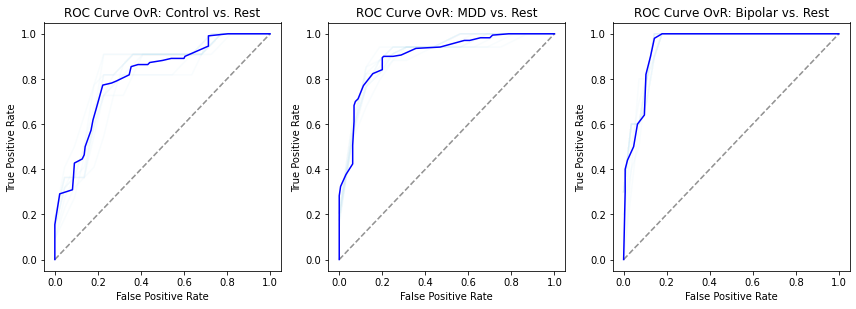

In [68]:
plt.figure(figsize = (12, 8))
roc_auc_ovr = {}
auc = []
    
for i in range(len(classes)):
    
    temptpr = []
    tempfpr = []
    
    for j in range(10):

        c = classes[i]

        df_aux = pd.DataFrame(testdata).copy()
        df_aux['class'] = [1 if y == c else 0 for y in testidx]
        df_aux['prob'] = np.array(prob2)[j][:, i]
        df_aux = df_aux.reset_index(drop = True)

        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])


        temptpr.append(tpr)
        tempfpr.append(fpr)
        
        plot_roc_curve_blue(tpr, fpr, scatter = False, ax = ax_bottom)
        
        
        ax_bottom.set_title(f"ROC Curve OvR: {classes_names[c]} vs. Rest")

        auc.append(roc_auc_score(df_aux['class'], df_aux['prob']))
    
    temptpr = np.array(temptpr)
    tempfpr = np.array(tempfpr)
    
    num = 9 + i * 10
    prev = 9 + (i-1)*10
    plt.plot(np.sort(np.array(pd.DataFrame(tempfpr).mean())), np.sort(np.array(pd.DataFrame(temptpr).mean())), 'b')

    plt.tight_layout()

/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.array([convert(v) for v in values])
/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in

/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.array([convert(v) for v in values])
/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in

/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.array([convert(v) for v in values])
/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in

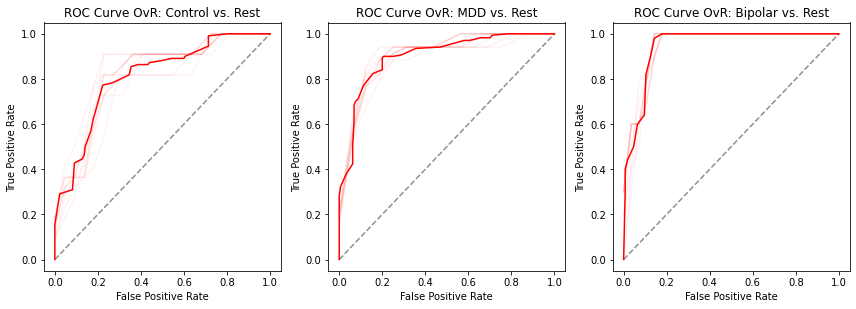

In [69]:
plt.figure(figsize = (12, 8))
roc_auc_ovr = {}
auc = []
    
for i in range(len(classes)):
    
    temptpr = []
    tempfpr = []
    
    for j in range(10):

        c = classes[i]

        df_aux = pd.DataFrame(testdata).copy()
        df_aux['class'] = [1 if y == c else 0 for y in testidx]
        df_aux['prob'] = np.array(prob2)[j][:, i]
        df_aux = df_aux.reset_index(drop = True)

        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])


        temptpr.append(tpr)
        tempfpr.append(fpr)
        
        plot_roc_curve_red(tpr, fpr, scatter = False, ax = ax_bottom)
        
        
        ax_bottom.set_title(f"ROC Curve OvR: {classes_names[c]} vs. Rest")

        auc.append(roc_auc_score(df_aux['class'], df_aux['prob']))
    
    temptpr = np.array(temptpr)
    tempfpr = np.array(tempfpr)
    
    num = 9 + i * 10
    prev = 9 + (i-1)*10
    plt.plot(np.sort(np.array(pd.DataFrame(tempfpr).mean())), np.sort(np.array(pd.DataFrame(temptpr).mean())), 'r')

    plt.tight_layout()

/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.array([convert(v) for v in values])
/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in

/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  values = np.array([convert(v) for v in values])
/home/koreagen/koreagen/lib/python3.8/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in

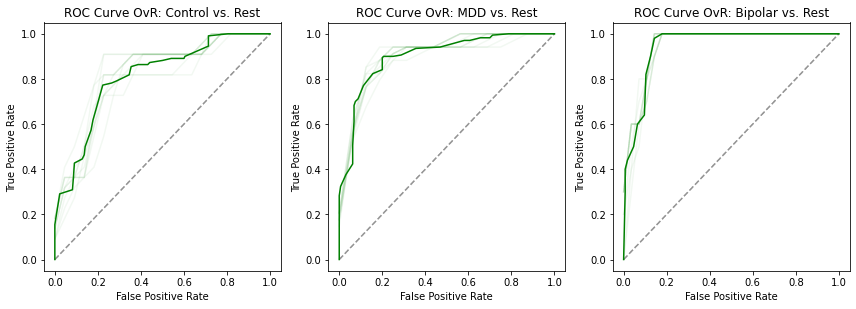

In [70]:
plt.figure(figsize = (12, 8))
roc_auc_ovr = {}
auc = []
    
for i in range(len(classes)):
    
    temptpr = []
    tempfpr = []
    
    for j in range(10):

        c = classes[i]

        df_aux = pd.DataFrame(testdata).copy()
        df_aux['class'] = [1 if y == c else 0 for y in testidx]
        df_aux['prob'] = np.array(prob2)[j][:, i]
        df_aux = df_aux.reset_index(drop = True)

        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        
        temptpr.append(tpr)
        tempfpr.append(fpr)
        
        plot_roc_curve_green(tpr, fpr, scatter = False, ax = ax_bottom)
        
        
        ax_bottom.set_title(f"ROC Curve OvR: {classes_names[c]} vs. Rest")

        auc.append(roc_auc_score(df_aux['class'], df_aux['prob']))
    
    temptpr = np.array(temptpr)
    tempfpr = np.array(tempfpr)
    
    num = 9 + i * 10
    prev = 9 + (i-1)*10
    plt.plot(np.sort(np.array(pd.DataFrame(tempfpr).mean())), np.sort(np.array(pd.DataFrame(temptpr).mean())), 'g')
    
    plt.tight_layout()

In [71]:
ctrlauc = np.mean(auc[:10])
ctrlauc

0.8152892561983471

In [72]:
mddauc = np.mean(auc[10:20])
mddauc

0.9066176470588235

In [73]:
bipauc = np.mean(auc[20:30])
bipauc

0.9492857142857142

In [74]:
totalauc = [ctrlauc, mddauc, bipauc]
aucinwhole = np.mean(totalauc)
aucinwhole

0.8903975391809617

In [75]:
testidx

array([1, 0, 2, 0, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 2, 1, 2, 0, 0, 1, 1, 0, 0, 2])

In [76]:
from sklearn.metrics import precision_recall_fscore_support

sens0 = []
spec0 = []
sens1 = []
spec1 = []
sens2 = []
spec2 = []

for i in range(10):
    for l in [0, 1, 2]:
        prec, recall, _, _ = precision_recall_fscore_support(np.array(testidx) == l, np.array(finalpred[i]) == l, pos_label = True, average = None)
        if l == 0:
            sens0.append(recall[0])
            spec0.append(recall[1])
        elif l == 1:
            sens1.append(recall[0])
            spec1.append(recall[1])
        else:
            sens2.append(recall[0])
            spec2.append(recall[1])
            
df = [[np.mean(sens0), np.mean(spec0)], [np.mean(sens1), np.mean(spec1)], [np.mean(sens2), np.mean(spec2)]]
print(pd.DataFrame(df))
print(pd.DataFrame(df).mean(axis=0))

          0         1
0  0.872727  0.381818
1  0.762500  0.917647
2  0.892857  0.720000
0    0.842695
1    0.673155
dtype: float64


In [77]:
np.mean([np.std(auc[:10]), np.std(auc[10:20]), np.std(auc[20:30])])

0.013021262359279756

In [78]:
np.mean(cv_acc)

0.70912

In [79]:
np.std(cv_acc)

0.024240000000000015

In [80]:
np.mean([np.std(sens0), np.std(sens1), np.std(sens2)])

0.019671689050830114

In [81]:
np.mean([np.std(spec0), np.std(spec1), np.std(spec2)])

0.05438691748688266

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

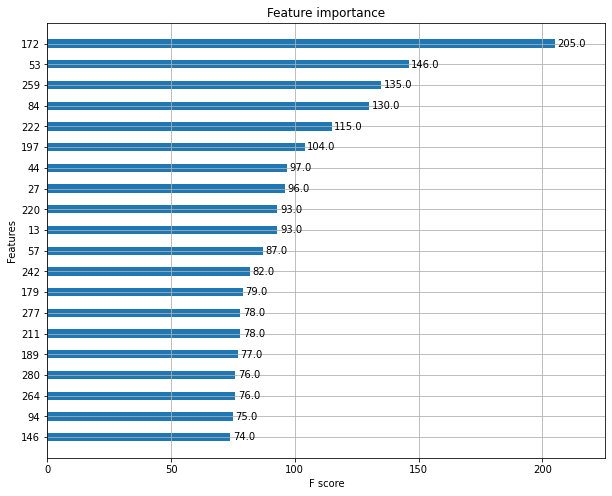

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
model.feature_names = list(snp.columns)
plot_importance(xgb_model, ax=ax, max_num_features=20, height=0.4)

In [83]:
import joblib
filename = './vit_xgboost100.pkl'
joblib.dump(xgb_model, filename)

['/home/koreagen/koreagen/gene_revision/vit_xgboost100.pkl']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

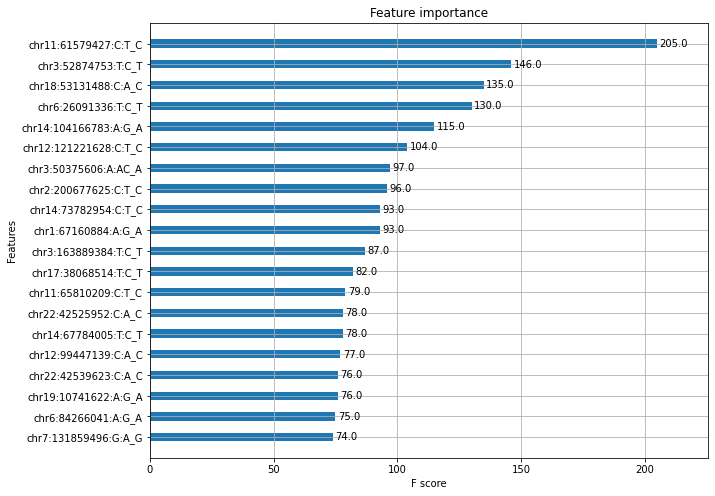

In [84]:
model = joblib.load(filename)
model.feature_names = list(snp.columns)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
xgb.plot_importance(model, ax=ax, max_num_features=20, height=0.4)